In [17]:
from models import *
from __future__ import print_function
from skimage.metrics import peak_signal_noise_ratio
import torch
import numpy as npy
import torch.optim

from utils.denoising_utils import *
import matplotlib.pyplot as plt
%matplotlib inline
import inspect
import skimage.measure
import os
from torch.utils.tensorboard import SummaryWriter

#?enable best algorithm for hardware  
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize =-1
PLOT = True
sigma = 25
sigma_ = sigma/255.

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [19]:
os.makedirs('models', exist_ok=True)

In [20]:
# load images
fname_us = "C:\\Users\\Leo\\Desktop\\FinalYearProject\\Dataf\\k3.jpg"
fname_mr = "C:\\Users\\Leo\\Desktop\\FinalYearProject\\Dataf\\k8.jpg"
fname_original = "C:\\Users\\Leo\\Desktop\\FinalYearProject\\Dataf\\k3.jpg"
print(fname_us)
print(fname_mr)

C:\Users\Leo\Desktop\FinalYearProject\Dataf\k3.jpg
C:\Users\Leo\Desktop\FinalYearProject\Dataf\k8.jpg


In [21]:
#Setup both picture
us = get_gray_image(fname_us,-1)[0]
mr = get_gray_image(fname_mr,-1)[0]
us_pil = us.resize((512,512),Image.ANTIALIAS)
us_np = pil_to_np(us_pil)
mr_pil = mr.resize((512,512),Image.ANTIALIAS)
mr_np = pil_to_np(mr_pil)
original_pil = crop_image(get_gray_image(fname_original,-1)[0],d=32)
original_pil = original_pil.resize((512,512),Image.ANTIALIAS)
original_np = pil_to_np(original_pil)

In [22]:


INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

reg_noise_std = 1./30. # set to 1./20. for sigma=50
LR = 0.01

OPTIMIZER='adam' # 'LBFGS'
show_every = 100
exp_weight=0.99


num_iter = 5000
input_depth = 1
figsize = 5 

net = skip(
            input_depth, 1, 
            num_channels_down = [8, 16, 32, 64, 128], 
            num_channels_up   = [8, 16, 32, 64, 128],
            num_channels_skip = [0, 0, 0, 4, 4], 
            upsample_mode='bilinear',
            need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU')

net = net.type(dtype).to(device)

#net input is white noise
net_input = get_noise(input_depth, INPUT, (us_pil.size[1], us_pil.size[0])).type(dtype).detach().to(device)
#net_input = get_noise(input_depth, INPUT, (us.size[1], us.size[0])).type(dtype).detach().to(device)

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

us_noisy_torch = np_to_torch(us_np).type(dtype).to(device)
mr_noisy_torch = np_to_torch(mr_np).type(dtype).to(device)

Number of params: 572665


In [23]:
def tv_loss(x):
    """
    Isotropic TV loss.
    """
    dh = torch.abs(x[..., :, 1:] - x[..., :, :-1])
    dw = torch.abs(x[..., 1:, :] - x[..., :-1, :])
    return torch.sum(dh[..., :-1, :] + dw[..., :, :-1])

Starting optimization with ADAM


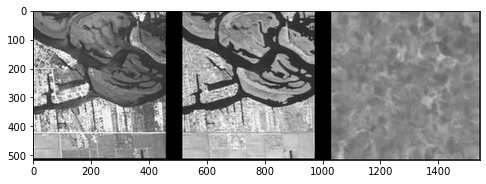

iteration =  0


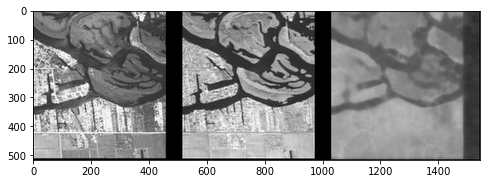

iteration =  100


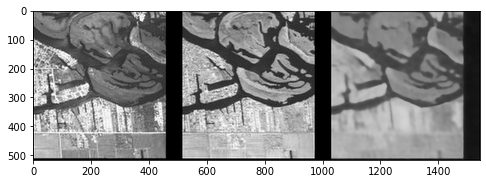

iteration =  200


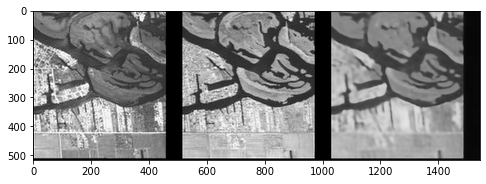

iteration =  300


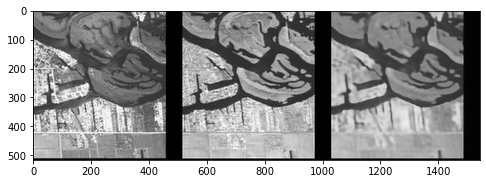

iteration =  400


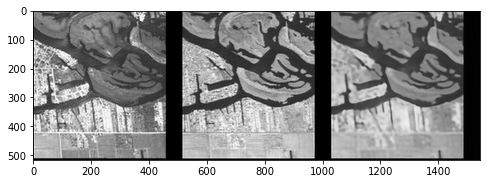

iteration =  500


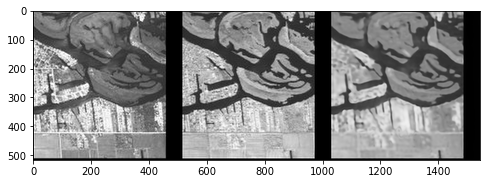

iteration =  600


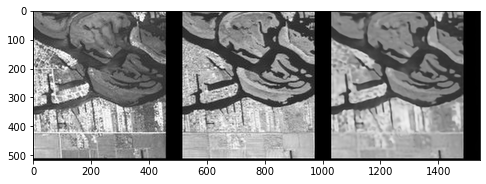

iteration =  700


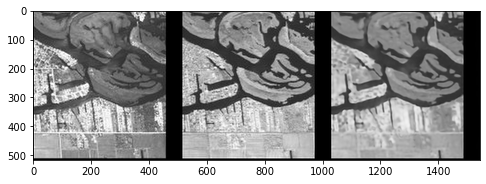

iteration =  800


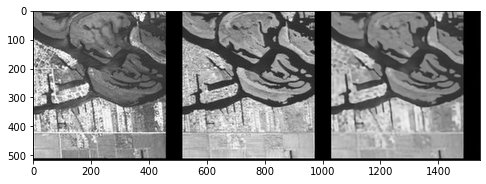

iteration =  900


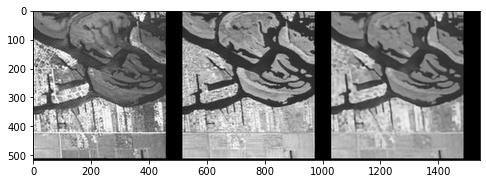

iteration =  1000


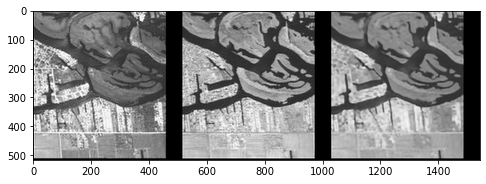

iteration =  1100


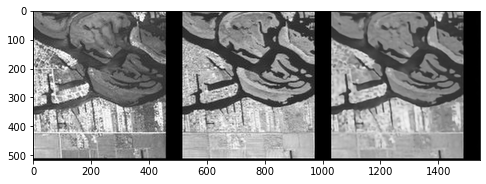

iteration =  1200


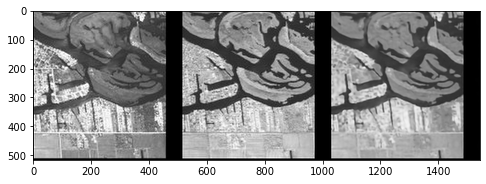

iteration =  1300


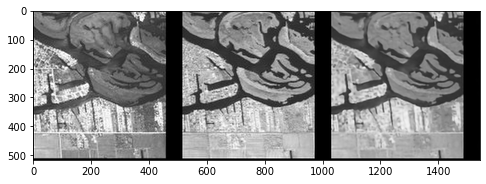

iteration =  1400


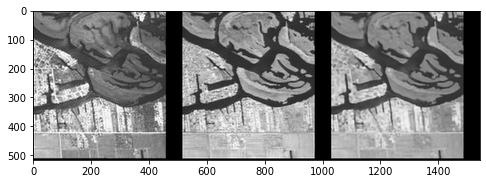

iteration =  1500


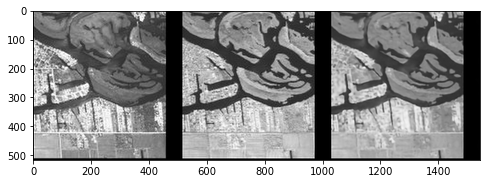

iteration =  1600


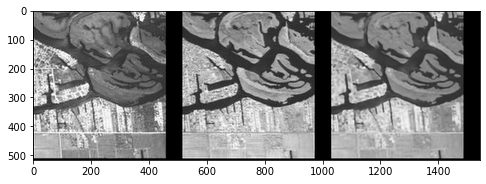

iteration =  1700


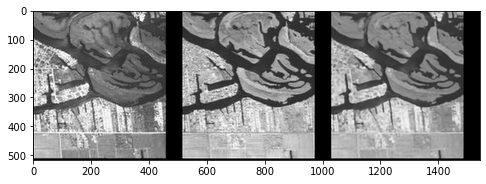

iteration =  1800


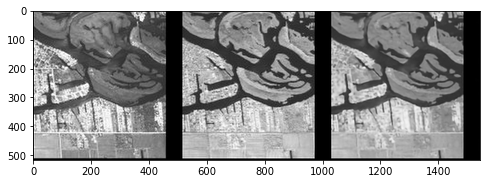

iteration =  1900


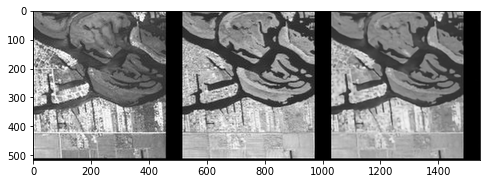

iteration =  2000


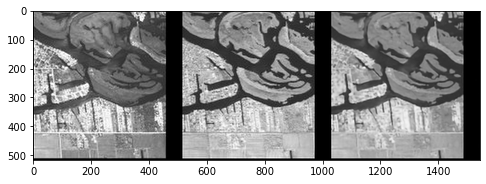

iteration =  2100


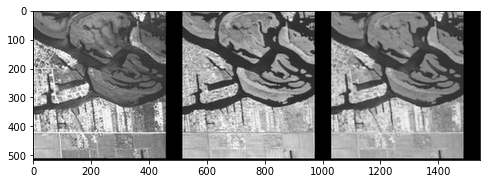

iteration =  2200


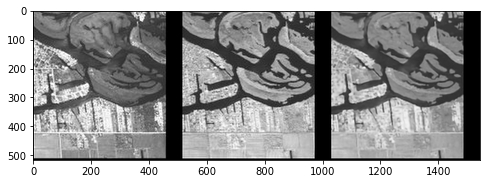

iteration =  2300


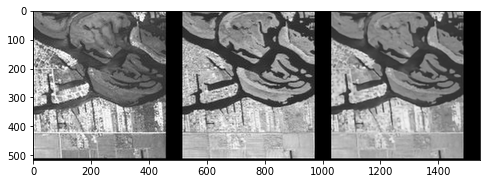

iteration =  2400


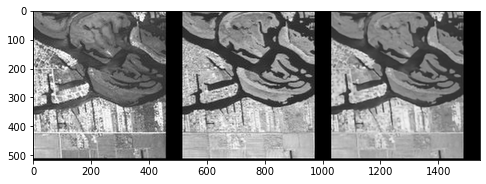

iteration =  2500


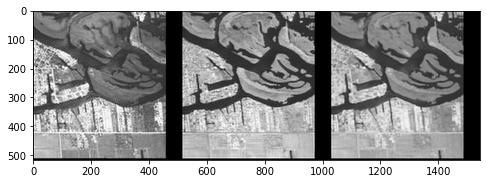

iteration =  2600


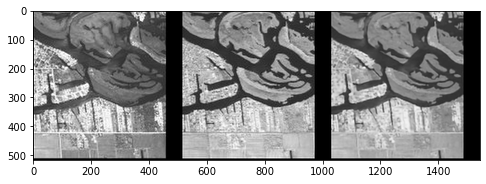

iteration =  2700


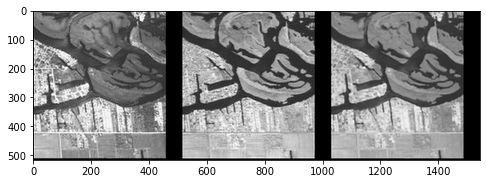

iteration =  2800


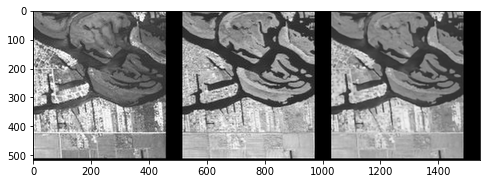

iteration =  2900


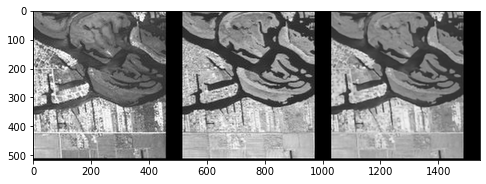

iteration =  3000


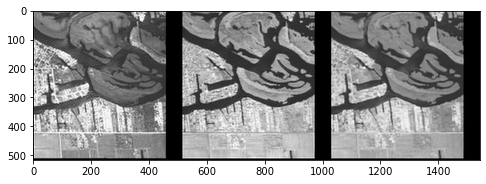

iteration =  3100


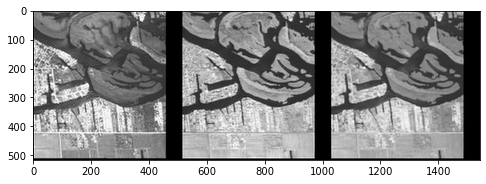

iteration =  3200


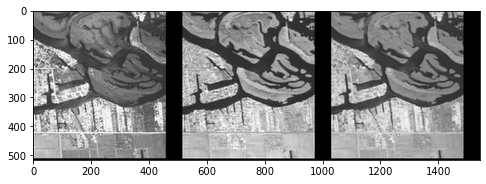

iteration =  3300


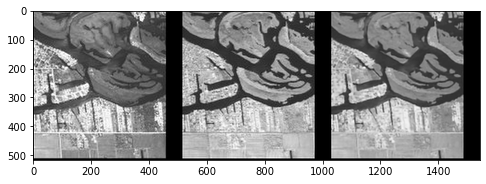

iteration =  3400


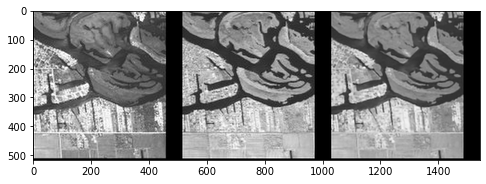

iteration =  3500


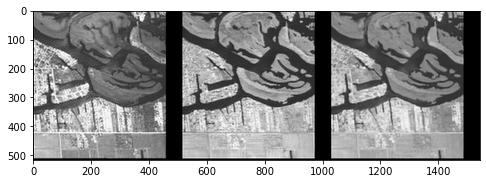

iteration =  3600


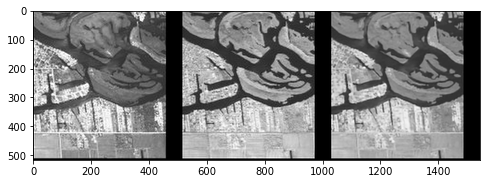

iteration =  3700


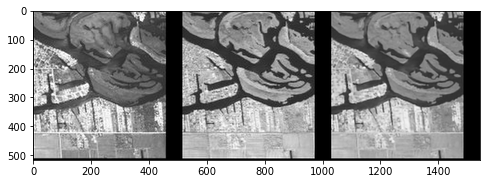

iteration =  3800


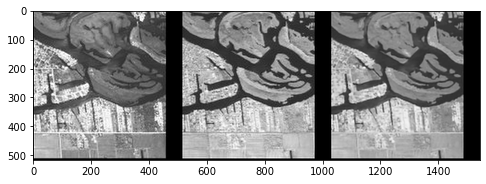

iteration =  3900


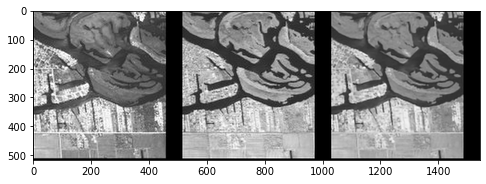

iteration =  4000


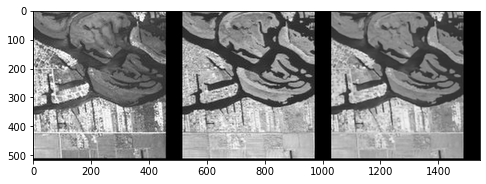

iteration =  4100


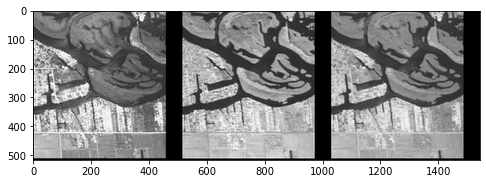

iteration =  4200


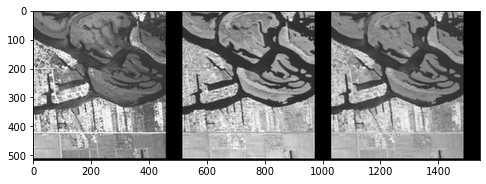

iteration =  4300


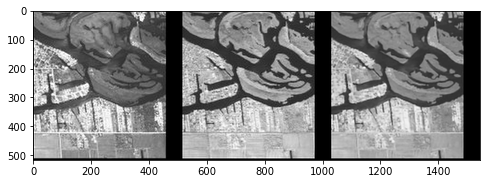

iteration =  4400


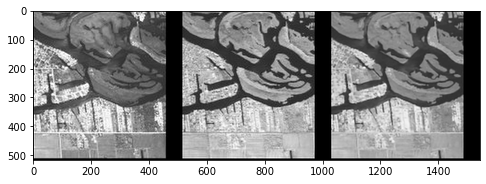

iteration =  4500


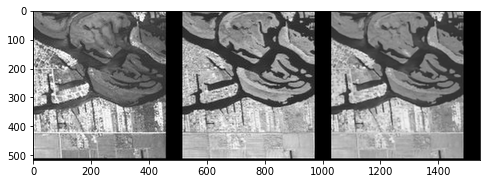

iteration =  4600


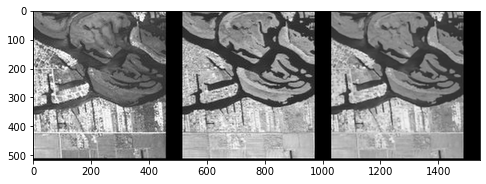

iteration =  4700


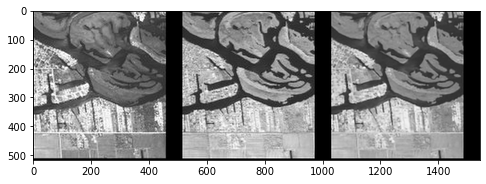

iteration =  4800


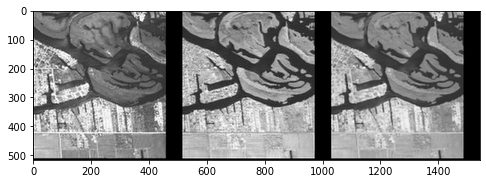

iteration =  4900


In [24]:
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0
us_para = 0.5
i = 0
def closure():
    
    global i, out_avg, psrn_noisy_last, last_net, net_input

    #xudong avoid start from the previous running result
    # if reg_noise_std > 0:
    #     net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    
    out = net(net_input).to(device)
    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)

    
    #linear combination of US and MR  mean square error  
    total_loss = us_para * mse(out, us_noisy_torch) + (1 - us_para) * mse(out,mr_noisy_torch) + 10**(-8) * tv_loss(out) *2
    # total_loss = mse(out, us_noisy_torch) + mse(out, mr_noisy_torch) + 10**(-5) * tv_loss(out) *2      + 10**(-8) * tv_loss(out) *2
    total_loss.backward()
        
    # print(us_np.shape)
    # print(out.detach().cpu().numpy()[0].shape)
    # ####only us image
    # print("--------------------------")
    # print(original_np.shape)
    psrn_noisy = peak_signal_noise_ratio(original_np, out.detach().cpu().numpy()[0]) 
    psrn_gt    = peak_signal_noise_ratio(us_np, out.detach().cpu().numpy()[0]) 
    psrn_gt_sm = peak_signal_noise_ratio(us_np, out_avg.detach().cpu().numpy()[0]) 
    
    # Note that we do not have GT for the "snail" example
    # So 'PSRN_gt', 'PSNR_gt_sm' make no sense
    print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(us_np,0,1),np.clip(mr_np,0,1),np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize, nrow=4)
        print("iteration = ",i)
        # plot_image_grid([np.clip(us_np,0,1),np.clip(mr_np,0,1),np.clip(out_np, 0, 1), 
        #                  np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize, nrow=4)
        
        
    
    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5: 
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy
            
    i += 1
    return total_loss
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)
torch.save(net, 'models/ex3.pth')

In [25]:
out = net(net_input).to(device)
img = np_to_pil(out.detach().cpu().numpy()[0])

In [26]:
plt.imsave("DIP_remote_fusion_remosensoing.jpg",out.detach().cpu().numpy()[0][0],cmap='gray')

In [27]:
def find_x_square_index(input_img_np):
    mean = np.mean(input_img_np)
    sum_t = 0
    for i in range(128):
        for j in range(128):
            sum_t += (input_img_np[0][i][j]-mean)**2
    return sum_t/16384      

print(find_x_square_index(out.detach().cpu().numpy()[0]))


def find_x_y_index(input_img_np_one,input_img_np_two):
    mean_one = np.mean(input_img_np_one)
    mean_two = np.mean(input_img_np_two)
    sum_t = 0
    for i in range(128):
        for j in range(128):
            sum_t += (input_img_np_one[0][i][j]-mean_one)*(input_img_np_two[0][i][j]-mean_two)
    return sum_t/16384

print(find_x_y_index(us_np,out.detach().cpu().numpy()[0])) 

0.02721788829242868
0.021595586202960208


In [28]:
def find_Q_zero(input_img_np_one,input_img_np_two):
    mean_one = np.mean(input_img_np_one)
    mean_two = np.mean(input_img_np_two)
    theta_xy = find_x_y_index(input_img_np_one,input_img_np_two)
    theta_x_square = find_x_square_index(input_img_np_one)
    theta_y_square = find_x_square_index(input_img_np_two)
    result = (4*theta_xy*mean_one*mean_two)/(((mean_one**2)+(mean_two**2))*(theta_x_square+theta_y_square))
    return result

print(find_Q_zero(us_np,out.detach().cpu().numpy()[0]))

0.923433390951201


In [29]:
def find_fusion_index(input_img_one,input_img_two,fusion_result):
    entropy_one = skimage.measure.shannon_entropy(input_img_one)
    entropy_two = skimage.measure.shannon_entropy(input_img_two)
    lambda_one = entropy_one/(entropy_one+entropy_two)
    lambda_two = 1-lambda_one

    img_original_np = pil_to_np(fusion_result)
    img_up_np = pil_to_np(input_img_one)
    img_down_np = pil_to_np(input_img_two)
    
    q_zero_one = find_Q_zero(img_up_np,img_original_np)
    q_zero_two = find_Q_zero(img_down_np,img_original_np)

    result = lambda_one * q_zero_one + lambda_two * q_zero_two

    return result

print(find_fusion_index(us_pil,mr_pil,img))

0.9361625311473389
